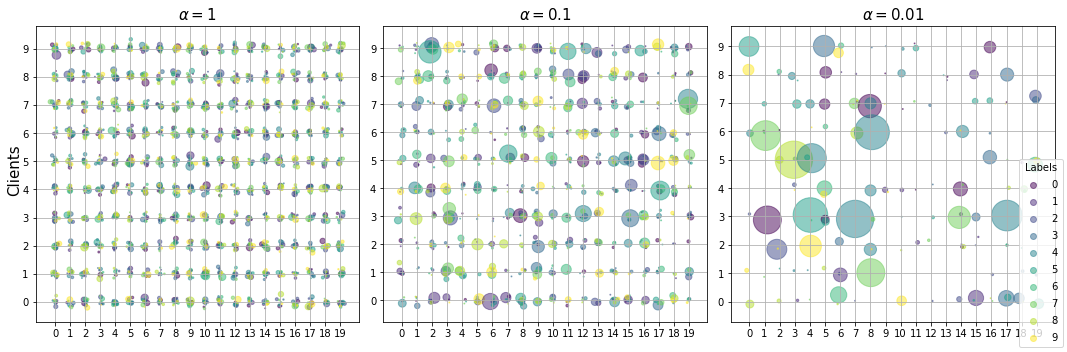

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from collections import Counter
import torch
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from torchvision import datasets
import numpy as np
from data import *
N_CLIENTS = 3400
DIRICHLET_ALPHA = 1

with h5py.File('./data_in_use/femnist.h5', 'r') as f:
    train_data, test_data = f['train'][:], f['test'][:]
    train_data[train_data['label'] < 10]


num_cls = 10

train_labels = np.array(train_data['label'])
client_idcs = dirichlet_split_noniid(
    train_labels, alpha=DIRICHLET_ALPHA, n_clients=N_CLIENTS)

g = {}
rounds=20
num_clients=10
num_labels=10

fig, ax = plt.subplots(1,3, figsize=(15, 5))
# fig.set_label('aaa')
alpha = [1, 0.1, 0.01]

for f in range(3):
    DIRICHLET_ALPHA = alpha[f]
    # 我们让每个client不同label的样本数量不同，以此做到Non-IID划分
    client_idcs = dirichlet_split_noniid(
        train_labels, alpha=DIRICHLET_ALPHA, n_clients=N_CLIENTS)
    r = []
    client = []
    label = []
    sample_num = []
    for i in range(rounds):
        np.random.shuffle(client_idcs)
        g = client_idcs[:num_clients]
        for j in range(num_labels):
            for k in range(num_clients):
                cnt=Counter(train_labels[g[k]])
                r += [i]
                label += [j]
                client += [k]
                sample_num += [cnt[j]]
    scale=0.1
    r = np.array(r)+np.random.normal(loc=0.0, scale=scale, size=len(r))
    client = np.array(client)+np.random.normal(loc=0.0, scale=scale, size=len(client))
    scatter=ax[f].scatter(r, client, c=label, s=sample_num, alpha=0.5)
    ax[f].set_xticks(np.arange(rounds))
    ax[f].set_yticks(np.arange(num_cls))
    # ax[f].set_xlabel('communication rounds')
    # ax[f].set_ylabel('Labels')
    ax[f].set_title(r'$\alpha={}$'.format(DIRICHLET_ALPHA),fontsize=15)
    ax[f].grid(True)
fig.legend(*scatter.legend_elements(),
                    loc="lower right", title="Labels")
fig.tight_layout()
# lines, labels = ax[-1].get_legend_handles_labels()

fig.supylabel('Clients',fontsize=15)
# fig.supxlabel('Communication Rounds',fontsize=15)
# fig.legend(legend)
fig.tight_layout()
fig.suptitle('')
fig.subplots_adjust(top=0.9)
fig.savefig('noniid.pdf', bbox_inches='tight')

plt.show()


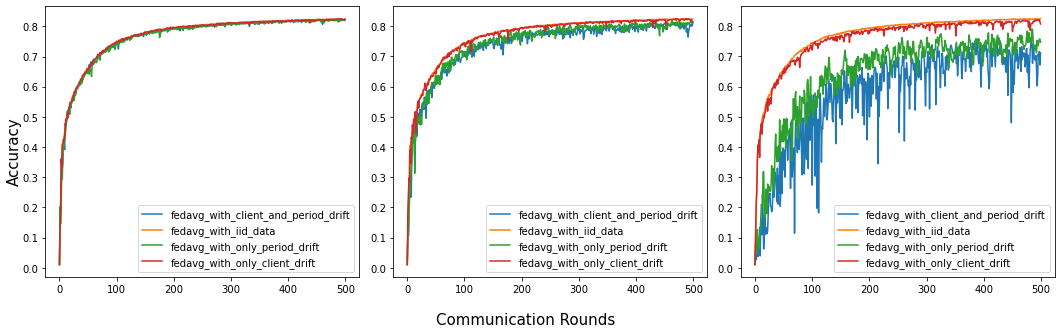

In [20]:
from utils import *
import matplotlib.pyplot as plt
dataset = 'femnist'
# method='centralized'
table = 'icml_period_client_drift_femnist'
h, l = {}, {}
alpha = [1, 0.1, 0.01]
d = {'method': [],
     'setting': [],
     'acc': []}
agg_loop = ['fedavg', 'fedprox', 'fedavgM',
            'feddf', 'fedmeta', 'pba', 'pba_prox']
iid_loop = ['alpha_1', 'alpha_0.1', 'alpha_0.01']
method = []
setting = []
acc = []
agg = 'fedavg'
iid = 'alpha_0.01'
fig, ax = plt.subplots(1, 3, sharex='col', figsize=(15, 5))
n = 0
nan=0
for iid in iid_loop:
    
    sql = "select * from icml_femnist where dataset='femnist' and method='fedavg' and iid='{}' and local_epochs=1;".format(iid)
    returns = sql_execute(sql, 'remote')
    h = eval(returns[-1]['recorder'])
    l = 'fedavg_with_client_and_period_drift'
    ax[n].plot(h['acc'][:500], label=l)
    
    sql = "select * from icml_period_client_drift_femnist where dataset='femnist' and method='fedavg_period_drift_only' and iid='iid' and local_epochs=1;"
    returns = sql_execute(sql, 'remote')
    h = eval(returns[-1]['recorder'])
    l = 'fedavg_with_iid_data'
    ax[n].plot(h['acc'][:500], label=l)
    
    sql = "select * from icml_period_client_drift_femnist where dataset='femnist' and method='fedavg_period_drift_only' and iid='{}' and local_epochs=1;".format(iid)
    returns = sql_execute(sql, 'remote')
    h = eval(returns[-1]['recorder'])
    l = 'fedavg_with_only_period_drift'
    ax[n].plot(h['acc'][:500], label=l)
    
    sql = "select * from icml_period_client_drift_femnist where dataset='femnist' and method='fedavg_client_drift_only' and iid='{}' and local_epochs=1;".format(iid)
    returns = sql_execute(sql, 'remote')
    h = eval(returns[-1]['recorder'])
    l = 'fedavg_with_only_client_drift'
    ax[n].plot(h['acc'][:500], label=l)
    
    lines, labels = ax[n].get_legend_handles_labels()
    ax[n].legend()
    d['method'] += [agg]
    d['setting'] += [iid]
    d['acc'] += [h['acc'][:500][-1]]
    
    # ax[n].set_title(r'$\alpha={}$'.format(alpha[n]),fontsize=15)
    
    
    n+=1
# fig.legend(*scatter.legend_elements(),
#            loc="lower right", title="Labels")
# fig.tight_layout()
# lines, labels = ax[-1].get_legend_handles_labels()

fig.supylabel('Accuracy', fontsize=15)
fig.supxlabel('Communication Rounds', fontsize=15)
# fig.legend(legend)
fig.tight_layout()
fig.suptitle('')
fig.subplots_adjust(top=0.9)
fig.savefig('seperate.pdf', bbox_inches='tight')
results = pd.DataFrame(d)
a = 1


In [13]:
n

3

In [4]:
from utils import *
dataset = 'femnist'
table = 'icml_femnist'
# tables = ['fedavg', 'fedavgm', 'fedprox',
#           'fedopt', 'fedeve']
methods = ["'fedavg'", "'fedavgm'", "'fedprox'",
           "'fedopt'", "'fedleo'"]
settings = ["'natural'", "'alpha_1'", "'alpha_0.1'", "'alpha_0.01'"]
tex = ''
n=100
nan=0
for i in range(len(methods)):
    line = methods[i]
    for iid in settings:
        sql = "select * from {} where dataset like '{}%' and method={} and iid={} and local_epochs=1;".format(table, dataset, methods[i], iid)
        returns = sql_execute(sql, 'remote')
        acc = sum(eval(returns[-1]['recorder'])['acc'][-n:])/n
        line += ' & ' + '$'+str(round(acc, 4))+'$'
    line += '\\'
    tex += line
tex


"'fedavg' & $0.8243$ & $0.8353$ & $0.8207$ & $0.7332$\\'fedavgm' & $0.8254$ & $0.8366$ & $0.8221$ & $0.7531$\\'fedprox' & $0.8241$ & $0.835$ & $0.8209$ & $0.744$\\'fedopt' & $0.0513$ & $0.8206$ & $0.7839$ & $0.5905$\\'fedeve' & $0.825$ & $0.8306$ & $0.8036$ & $0.6988$\\"

In [6]:
from utils import *
dataset = 'cifar100'
table = 'icml_cifar100'
# tables = ['fedavg', 'fedavgm', 'fedprox',
#           'fedopt', 'fedeve']
methods = ["'fedavg'", "'fedavgm'", "'fedprox'",
           "'fedopt'", "'fedeve'"]
settings = ["'alpha_1'", "'alpha_0.1'", "'alpha_0.01'"]
tex = ''
n=100
nan=0
for i in range(len(methods)):
    line = methods[i]
    for iid in settings:
        sql = "select * from {} where dataset like '{}%' and method={} and iid={} and local_epochs=1;".format(table, dataset, methods[i], iid)
        returns = sql_execute(sql, 'remote')
        acc = sum(eval(returns[-1]['recorder'])['acc'][-n:])/n
        line += ' & ' + '$'+str(round(acc, 4))+'$'
    line += '\\'
    tex += line
tex

"'fedavg' & $0.468$ & $0.4399$ & $0.291$\\'fedavgm' & $0.2431$ & $0.2103$ & $0.139$\\'fedprox' & $0.4661$ & $0.4386$ & $0.2913$\\'fedopt' & $0.5214$ & $0.5063$ & $0.3487$\\'fedeve' & $0.4301$ & $0.4368$ & $0.2927$\\"

In [31]:
from utils import *
dataset = 'ml-1m'
table = 'icml_ml_1m'
# tables = ['fedavg', 'fedavgm', 'fedprox',
#           'fedopt', 'fedeve']
methods = ["'fedavg'", "'fedavgm'", "'fedprox'",
           "'fedopt'", "'fedeve'"]
settings = ["'natural'", "'alpha_1'", "'alpha_0.1'", "'alpha_0.01'"]
matrics = ['auc', 'hit5', 'hit10', 'ndcg5', 'ndcg10']
tex = ''
n=100
nan=0
for i in range(len(methods)):
    line = methods[i]
    for matric in matrics:
        sql = "select * from {} where dataset like '{}%' and method={} and local_epochs=1;".format(table, dataset, methods[i])
        if 'fedeve' in line:
            sql = "select * from icml_fedeve_ml_1m where dataset like '{}%' and method={} and local_epochs=1;".format(dataset, methods[i])
        returns = sql_execute(sql, 'remote')
        acc = sum(eval(returns[-1]['recorder'])[matric][-n:])/n
        line += ' & ' + '$'+str(round(acc, 4))+'$'
    line += '\\'
    tex += line
tex


"'fedavg' & $0.7986$ & $0.2898$ & $0.4359$ & $0.1897$ & $0.2367$\\'fedavgm' & $0.8017$ & $0.2873$ & $0.4421$ & $0.1892$ & $0.239$\\'fedprox' & $0.7615$ & $0.2827$ & $0.431$ & $0.181$ & $0.2288$\\'fedopt' & $0.7994$ & $0.2882$ & $0.4392$ & $0.1907$ & $0.2391$\\'fedeve' & $0.7986$ & $0.2875$ & $0.4399$ & $0.1928$ & $0.2417$\\"

In [30]:
line


"'fedeve' & $0.7986$"

In [ ]:
from utils import *
dataset = 'femnist'
table = 'icml_femnist'
# tables = ['fedavg', 'fedavgm', 'fedprox',
#           'fedopt', 'fedeve']
methods = ["'fedavg'", "'fedavgm'", "'fedprox'",
           "'fedopt'", "'fedleo'"]
settings = ["'natural'", "'alpha_1'", "'alpha_0.1'", "'alpha_0.01'"]
tex = ''
n = 100
nan = 0
for i in range(len(methods)):
    line = methods[i]
    for iid in settings:
        sql = "select * from {} where dataset like '{}%' and method={} and iid={} and local_epochs=1;".format(
            table, dataset, methods[i], iid)
        returns = sql_execute(sql, 'remote')
        acc = sum(eval(returns[-1]['recorder'])['acc'][-n:])/n
        line += ' & ' + '$'+str(round(acc, 4))+'$'
    line += '\\'
    tex += line
tex


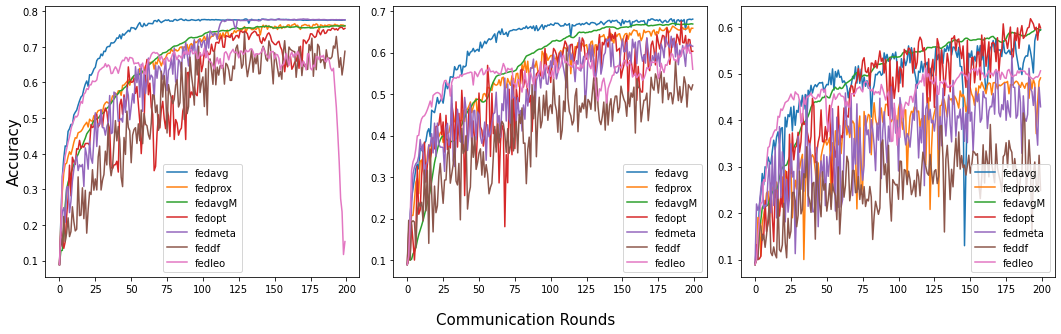

In [24]:
from utils import *
import matplotlib.pyplot as plt
dataset = 'femnist'
# method='centralized'
table = 'icml_period_client_drift_femnist'
h, l = {}, {}
alpha = [1, 0.1, 0.01]
d = {'method': [],
     'setting': [],
     'acc': []}
agg_loop = ['fedavg', 'fedprox', 'fedavgM',
            'fedopt', 'fedmeta', 'feddf', 'fedleo']
iid_loop = ['alpha_1', 'alpha_0.1', 'alpha_0.01']
method = []
setting = []
acc = []
agg = 'fedavg'
iid = 'alpha_0.01'
fig, ax = plt.subplots(1, 3, sharex='col', figsize=(15, 5))
n = 0
nan = 0
for iid in iid_loop:
    for agg in agg_loop:
        sql = "select * from kdd_cifar10 where dataset='cifar10' and method='{}' and iid='{}' and clients_per_round=10;".format(agg,
            iid)
        returns = sql_execute(sql, 'remote')
        try:
            h = eval(returns[-1]['recorder'])
            l = agg
        
            ax[n].plot(h['acc'][:200], label=l)
        except:
            pass

        lines, labels = ax[n].get_legend_handles_labels()
        ax[n].legend()
        d['method'] += [agg]
        d['setting'] += [iid]
        d['acc'] += [h['acc'][:200][-1]]

    # ax[n].set_title(r'$\alpha={}$'.format(alpha[n]),fontsize=15)

    n += 1
# fig.legend(*scatter.legend_elements(),
#            loc="lower right", title="Labels")
# fig.tight_layout()
# lines, labels = ax[-1].get_legend_handles_labels()

fig.supylabel('Accuracy', fontsize=15)
fig.supxlabel('Communication Rounds', fontsize=15)
# fig.legend(legend)
fig.tight_layout()
fig.suptitle('')
fig.subplots_adjust(top=0.9)
fig.savefig('seperate.pdf', bbox_inches='tight')
results = pd.DataFrame(d)
a = 1


In [16]:
returns
sql

"select * from kdd_femnist where dataset='femnist' and method='fedmeta' and iid='alpha_1' and clients_per_round=10;"